In [2]:
!git clone https://github.com/ShihaoCui/Mydata_1.git

Cloning into 'Mydata_1'...
remote: Enumerating objects: 295, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 295 (delta 33), reused 93 (delta 26), pack-reused 195
Receiving objects: 100% (295/295), 297.78 MiB | 23.56 MiB/s, done.
Resolving deltas: 100% (58/58), done.
Checking out files: 100% (202/202), done.


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Dense,RepeatVector, LSTM, Dropout,GRU
from tensorflow.keras.layers import Flatten, Conv1D, MaxPooling1D,TimeDistributed,Input
from tensorflow.keras.layers import Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from keras.layers import SimpleRNN
from keras import optimizers
import tensorflow as tf
import time
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from pylab import mpl
# import pandas_profiling as ppf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import plot_model #绘图（模型结构）
import seaborn as sns
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False
df=pd.read_csv('./Mydata_1/DispersionCurveML/cnn_lstm_attention/AQI.csv')
df.drop(columns=['date'],inplace=True)
df=df[['hour', 'PM2.5', 'PM10', 'SO2', 'NO2', 'O3', 'CO', '气压', '海平面气压', '温度', '相对湿度', '降水量', '最大风速','AQI']]
df

,hour,PM2.5,PM10,SO2,NO2,O3,CO,气压,海平面气压,温度,相对湿度,降水量,最大风速,AQI
0,8,10,14,5,17,41,0.60,966.1,1021.0,14.7,89.0,0.0,2.3,14
1,9,12,18,5,19,37,0.61,966.5,1021.4,15.1,86.0,0.0,2.6,18
2,10,13,18,5,22,32,0.60,966.7,1021.6,15.6,85.0,0.0,2.9,19
3,11,12,17,5,22,32,0.67,966.7,1021.5,16.0,83.0,0.0,2.8,17
4,12,11,16,5,22,36,0.64,966.2,1021.0,16.7,80.0,0.0,2.0,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12293,19,40,63,4,30,124,0.62,963.7,1018.4,18.8,56.0,0.0,1.7,57
12294,20,45,71,4,47,94,0.70,965.0,1020.1,16.1,73.0,0.0,2.2,63
12295,21,49,80,5,76,49,0.85,966.1,1021.3,15.0,84.0,0.0,2.7,68
12296,22,53,89,4,95,25,1.02,966.6,1021.9,13.7,93.0,0.0,3.1,73


In [11]:
def load_data(data, time_step=2, after_day=1, validate_percent=0.8):
    seq_length = time_step + after_day
    result = []
    for index in range(len(data) - seq_length + 1):
        result.append(data[index: index + seq_length])
    result = np.array(result)
    print('total data \n', result.shape)
    train_size = int(len(result) * validate_percent)
    train = result[:train_size, :]
    validate = result[train_size:, :]

    x_train = train[:, :time_step]
    y_train = train[:, time_step:][:,:,-1]#取最后一列
    x_validate = validate[:, :time_step]
    y_validate = validate[:, time_step:][:,:,-1]#取最后一列
    scaler1 = MinMaxScaler(feature_range=(0, 1))
    x_train=scaler1.fit_transform(x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2])).reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2])
    x_validate=scaler1.transform(x_validate.reshape(x_validate.shape[0],x_validate.shape[1]*x_validate.shape[2])).reshape(x_validate.shape[0],x_validate.shape[1],x_validate.shape[2])
    scaler2 = MinMaxScaler(feature_range=(0, 1))
    y_train=scaler2.fit_transform(y_train)
    y_validate=scaler2.transform(y_validate)
            
    return [scaler1,scaler2,result,x_train, y_train, x_validate, y_validate]
# scaler1 = MinMaxScaler(feature_range=(0, 1))
# df = scaler1.fit_transform(df)
n1=30
n2=10
scaler1,scaler2,data,x_train, y_train, x_test, y_test = load_data(df,time_step=n1, after_day=n2, validate_percent=0.8)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

total data 
 (12259, 40, 14)
(9807, 30, 14) (9807, 10)
(2452, 30, 14) (2452, 10)


## cnn-lstm

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 30, 128)           5504      
                                                                 
 dropout_2 (Dropout)         (None, 30, 128)           0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 15, 128)          0         
 1D)                                                             
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 flatten_1 (Flatten)         (None, 128)               0         
                                                      

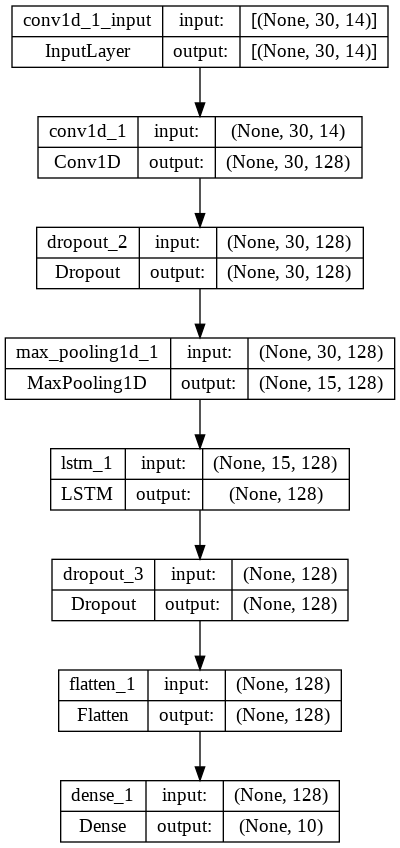

In [12]:
import random
import os
import tensorflow as tf
def seed_tensorflow(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed_tensorflow(seed=2)

model = Sequential()
# model.add(Input(shape=(n1, 14)))
model.add(Conv1D(128, 3, padding='same', strides = 1,activation = 'relu',input_shape=(n1, 14)))
model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=2))
# model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.1, return_sequences = True))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Flatten())
# model.add(Dense(128))
model.add(Dense(n2))
model.summary()
plot_model(model=model, to_file='model_cnn_lstm.png', show_shapes=True)

In [13]:
RMSprop =tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(loss='mse', optimizer=RMSprop, metrics=['mse'])
history=model.fit(x_train, y_train, epochs=5,batch_size=32, verbose=2,validation_data=(x_test, y_test),shuffle=False,callbacks =[
                                  tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')])

Epoch 1/5
307/307 - 18s - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0123 - val_mse: 0.0123 - 18s/epoch - 60ms/step
Epoch 2/5
307/307 - 12s - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0082 - val_mse: 0.0082 - 12s/epoch - 41ms/step
Epoch 3/5
307/307 - 11s - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0070 - val_mse: 0.0070 - 11s/epoch - 37ms/step
Epoch 4/5
307/307 - 11s - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0057 - val_mse: 0.0057 - 11s/epoch - 35ms/step
Epoch 5/5
307/307 - 11s - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0056 - val_mse: 0.0056 - 11s/epoch - 35ms/step


In [14]:
#测试数据误差
from sklearn.metrics import mean_squared_error #均方误差
from sklearn.metrics import mean_absolute_error #平方绝对误差
from sklearn.metrics import r2_score#R square
from sklearn.metrics import mean_absolute_percentage_error
y_test_predict1=scaler2.inverse_transform(model.predict(x_test))[:,0]
y_test1=scaler2.inverse_transform(y_test)[:,0]
cnn_lstm_rmse=round(mean_squared_error(y_test_predict1,y_test1)**0.5,2)
cnn_lstm_mse=round(mean_squared_error(y_test_predict1,y_test1),2)
cnn_lstm_r2=round(r2_score(y_test_predict1,y_test1),2)
cnn_lstm_mae=round(mean_absolute_error(y_test_predict1,y_test1),2)
cnn_lstm_mape=str(round(mean_absolute_percentage_error(y_test_predict1,y_test1)*100,2))+'%'
print('test rmse',cnn_lstm_rmse,'test mse',cnn_lstm_mse,'test mae',cnn_lstm_mae,'test mape',cnn_lstm_mape,'test r2',cnn_lstm_r2)
y_train_predict1=scaler2.inverse_transform(model.predict(x_train))

77/77 [==============================] - 1s 13ms/step
test rmse 11.75 test mse 138.02 test mae 8.69 test mape 11.49% test r2 0.85
307/307 [==============================] - 4s 13ms/step


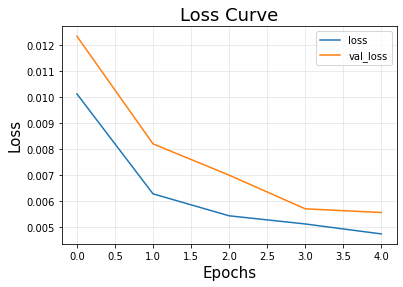

In [15]:
plt.plot(history.epoch,history.history['loss'],label="loss") # Loss curve for training set
plt.plot(history.epoch,history.history['val_loss'],label="val_loss") # Loss curve for validation set

plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 30495 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23454 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 30495 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 23454 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20540 missing from current font.
  font.set_text

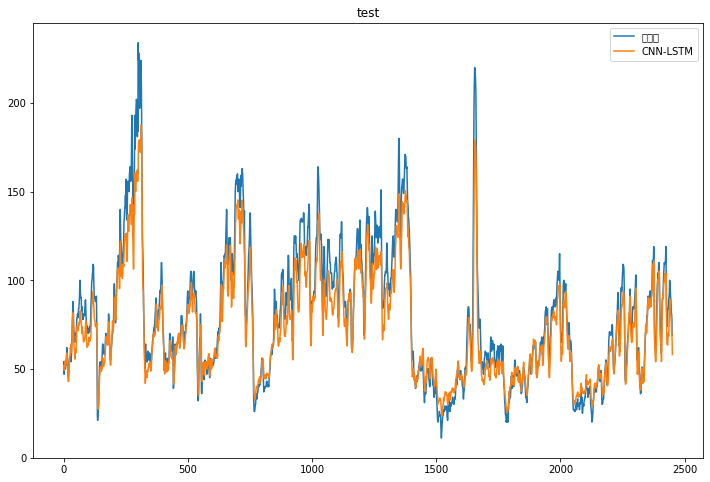

In [16]:
#训练和测试 真实值和预测值对比
plt.figure(figsize=(12, 8))
# plt.subplot(2, 2, 1)
sns.lineplot(x=range(len(y_test1)),y=y_test1,label='真实值')
sns.lineplot(x=range(len(y_test_predict1)),y=y_test_predict1,label='CNN-LSTM')
plt.legend()
plt.title('test')
# plt.subplot(2, 2, 2)
# sns.lineplot(x=range(len(y_train1)),y=y_train1.reshape(1,-1)[0],label='true')
# sns.lineplot(x=range(len(y_train_predict1)),y=y_train_predict1.reshape(1,-1)[0],label='predict')
# plt.legend()
# plt.title('train')
plt.show()

## cnn-bilstm

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 30, 128)           5504      
                                                                 
 dropout_4 (Dropout)         (None, 30, 128)           0         
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 15, 128)          0         
 1D)                                                             
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 10)               

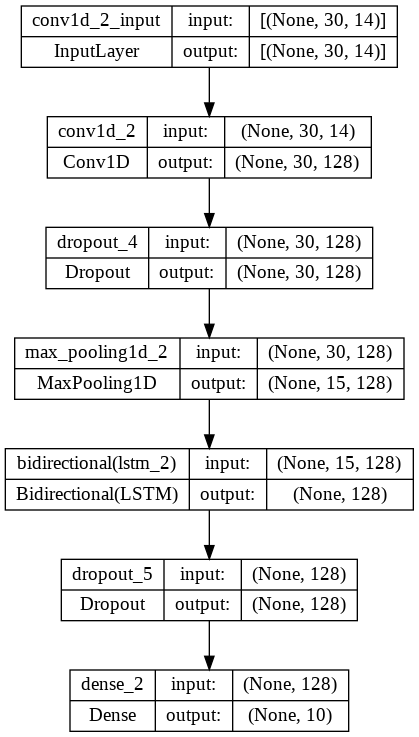

In [17]:
import random
import os
import tensorflow as tf
def seed_tensorflow(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed_tensorflow(seed=2)

model = Sequential()
# model.add(Input(shape=(n1, 14)))
model.add(Conv1D(128, 3, padding='same', strides = 1,activation = 'relu',input_shape=(n1, 14)))
model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=2))
# model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.1, return_sequences = True))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.2))
model.add(Dense(n2))
model.summary()
plot_model(model=model, to_file='model_cnn_bilstm.png', show_shapes=True)

In [18]:
RMSprop =tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(loss='mse', optimizer=RMSprop, metrics=['mse'])
history=model.fit(x_train, y_train, epochs=5,batch_size=64, verbose=2,validation_data=(x_test, y_test),shuffle=False,callbacks =[
                                  tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')])

Epoch 1/5
154/154 - 13s - loss: 0.0131 - mse: 0.0131 - val_loss: 0.0146 - val_mse: 0.0146 - 13s/epoch - 82ms/step
Epoch 2/5
154/154 - 8s - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0113 - val_mse: 0.0113 - 8s/epoch - 50ms/step
Epoch 3/5
154/154 - 8s - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0083 - val_mse: 0.0083 - 8s/epoch - 50ms/step
Epoch 4/5
154/154 - 8s - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0065 - val_mse: 0.0065 - 8s/epoch - 49ms/step
Epoch 5/5
154/154 - 8s - loss: 0.0055 - mse: 0.0055 - val_loss: 0.0060 - val_mse: 0.0060 - 8s/epoch - 49ms/step


In [19]:
#测试数据误差
from sklearn.metrics import mean_squared_error #均方误差
from sklearn.metrics import mean_absolute_error #平方绝对误差
from sklearn.metrics import r2_score#R square
from sklearn.metrics import mean_absolute_percentage_error
y_test_predict2=scaler2.inverse_transform(model.predict(x_test))[:,0]
y_test1=scaler2.inverse_transform(y_test)[:,0]
cnn_bilstm_rmse=round(mean_squared_error(y_test_predict2,y_test1)**0.5,2)
cnn_bilstm_mse=round(mean_squared_error(y_test_predict2,y_test1),2)
cnn_bilstm_r2=round(r2_score(y_test_predict2,y_test1),2)
cnn_bilstm_mae=round(mean_absolute_error(y_test_predict2,y_test1),2)
cnn_bilstm_mape=str(round(mean_absolute_percentage_error(y_test_predict2,y_test1)*100,2))+'%'
print('test rmse',cnn_bilstm_rmse,'test mse',cnn_bilstm_mse,'test mae',cnn_bilstm_mae,'test mape',cnn_bilstm_mape,'test r2',cnn_bilstm_r2)
y_train_predict2=scaler2.inverse_transform(model.predict(x_train))

77/77 [==============================] - 1s 8ms/step
test rmse 11.49 test mse 132.07 test mae 8.66 test mape 12.22% test r2 0.87
307/307 [==============================] - 3s 9ms/step


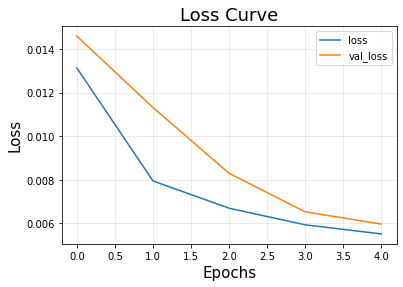

In [20]:
plt.plot(history.epoch,history.history['loss'],label="loss") # Loss curve for training set
plt.plot(history.epoch,history.history['val_loss'],label="val_loss") # Loss curve for validation set

plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 30495 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23454 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 30495 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 23454 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20540 missing from current font.
  font.set_text

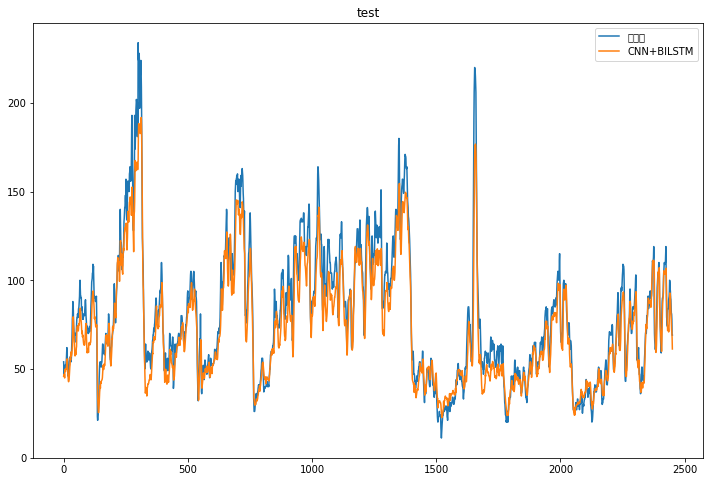

In [21]:
#训练和测试 真实值和预测值对比
plt.figure(figsize=(12, 8))
# plt.subplot(2, 2, 1)
sns.lineplot(x=range(len(y_test1)),y=y_test1,label='真实值')
sns.lineplot(x=range(len(y_test_predict2)),y=y_test_predict2,label='CNN+BILSTM')
plt.legend()
plt.title('test')
# plt.subplot(2, 2, 2)
# sns.lineplot(x=range(len(y_train1)),y=y_train1.reshape(1,-1)[0],label='true')
# sns.lineplot(x=range(len(y_train_predict1)),y=y_train_predict1.reshape(1,-1)[0],label='predict')
# plt.legend()
# plt.title('train')
plt.show()

## cnn-bilstm+attention

In [31]:
# from keras.layers import merge
import random
from keras.layers.core import *
from keras.models import *
from keras.layers import Multiply
import os
import tensorflow as tf
SINGLE_ATTENTION_VECTOR = False
# https://blog.csdn.net/qq_35649669/article/details/103807915
def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, n1))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(n1, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

# 注意力机制的另一种写法 适合上述报错使用 来源:https://blog.csdn.net/uhauha2929/article/details/80733255
def attention_3d_block2(inputs, single_attention_vector=False):
    # 如果上一层是LSTM，需要return_sequences=True
    # inputs.shape = (batch_size, time_steps, input_dim)
    time_steps = K.int_shape(inputs)[1]
    input_dim = K.int_shape(inputs)[2]
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax')(a)
    if single_attention_vector:
        a = Lambda(lambda x: K.mean(x, axis=1))(a)
        a = RepeatVector(input_dim)(a)
        a_probs = Permute((2, 1), name='attention_vec')(a)
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 14)]     0           []                               
                                                                                                  
 conv1d_3 (Conv1D)              (None, 30, 256)      3840        ['input_1[0][0]']                
                                                                                                  
 dropout_6 (Dropout)            (None, 30, 256)      0           ['conv1d_3[0][0]']               
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 30, 512)     1050624     ['dropout_6[0][0]']              
 )                                                                                            

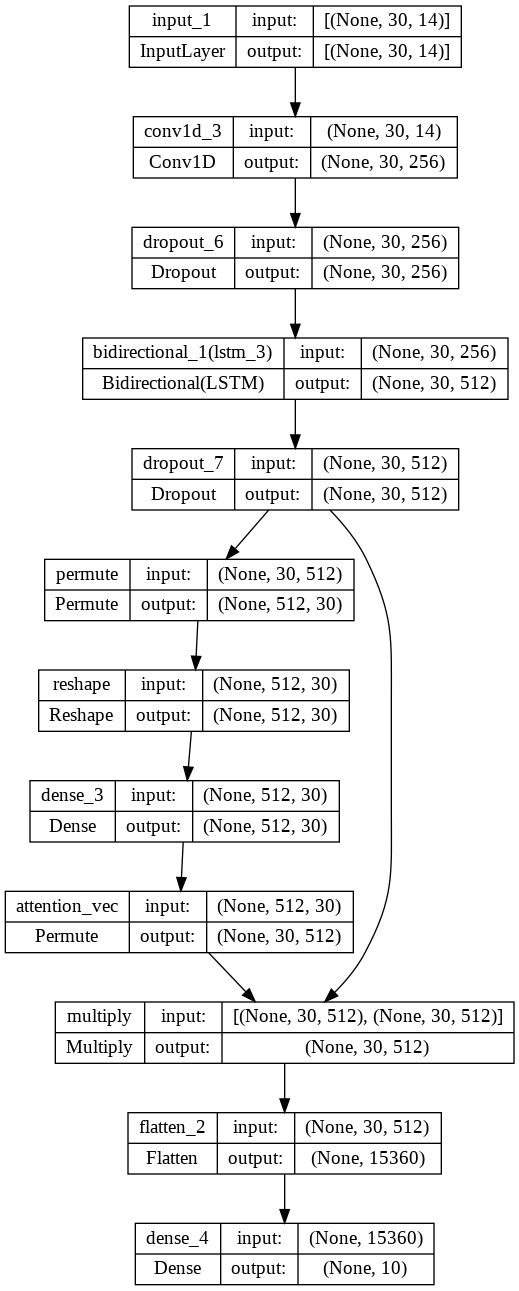

In [24]:
def seed_tensorflow(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed_tensorflow(seed=2)

def attention_model():
    inputs = Input(shape=(n1, 14))
    x = Conv1D(filters = 256, kernel_size = 1, activation = 'relu')(inputs)  #, padding = 'same'
    x = Dropout(0.2)(x)
    lstm_out = Bidirectional(LSTM(256, return_sequences=True))(x)
    lstm_out = Dropout(0.2)(lstm_out)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)

    output = Dense(n2, activation='sigmoid')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    return model
model=attention_model()
model.summary()
plot_model(model=model, to_file='model_cnn_bilstm_attention.png', show_shapes=True)

In [25]:
RMSprop =tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(loss='mse', optimizer=RMSprop, metrics=['mse'])
history=model.fit(x_train, y_train, epochs=10,batch_size=32, verbose=2,validation_data=(x_test, y_test),shuffle=False,callbacks =[
                                  tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')])

Epoch 1/10
307/307 - 118s - loss: 0.0117 - mse: 0.0117 - val_loss: 0.0093 - val_mse: 0.0093 - 118s/epoch - 384ms/step
Epoch 2/10
307/307 - 114s - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0063 - val_mse: 0.0063 - 114s/epoch - 372ms/step
Epoch 3/10
307/307 - 111s - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0071 - val_mse: 0.0071 - 111s/epoch - 363ms/step
Epoch 4/10
307/307 - 109s - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0065 - val_mse: 0.0065 - 109s/epoch - 357ms/step
Epoch 5/10
307/307 - 110s - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0055 - val_mse: 0.0055 - 110s/epoch - 360ms/step
Epoch 6/10
307/307 - 113s - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0054 - val_mse: 0.0054 - 113s/epoch - 368ms/step
Epoch 7/10
307/307 - 117s - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0084 - val_mse: 0.0084 - 117s/epoch - 381ms/step
Epoch 8/10
307/307 - 113s - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0059 - val_mse: 0.0059 - 113s/epoch - 367ms/step
Epoch 9/10
307/307 - 110s - loss: 0.0044 - mse: 0.0044 -

In [26]:
#测试数据误差
from sklearn.metrics import mean_squared_error #均方误差
from sklearn.metrics import mean_absolute_error #平方绝对误差
from sklearn.metrics import r2_score#R square
from sklearn.metrics import mean_absolute_percentage_error
y_test_predict3=scaler2.inverse_transform(model.predict(x_test))[:,0]
y_test1=scaler2.inverse_transform(y_test)[:,0]
cnn_bilstm_a_rmse=round(mean_squared_error(y_test_predict3,y_test1)**0.5,2)
cnn_bilstm_a_mse=round(mean_squared_error(y_test_predict3,y_test1),2)
cnn_bilstm_a_r2=round(r2_score(y_test_predict3,y_test1),2)
cnn_bilstm_a_mae=round(mean_absolute_error(y_test_predict3,y_test1),2)
cnn_bilstm_a_mape=str(round(mean_absolute_percentage_error(y_test_predict3,y_test1)*100,2))+'%'
print('test rmse',cnn_bilstm_a_rmse,'test mse',cnn_bilstm_a_mse,'test mae',cnn_bilstm_a_mae,'test mape',cnn_bilstm_a_mape,'test r2',cnn_bilstm_a_r2)
y_train_predict3=scaler2.inverse_transform(model.predict(x_train))

77/77 [==============================] - 7s 84ms/step
test rmse 15.52 test mse 240.73 test mae 10.49 test mape 12.29% test r2 0.88
307/307 [==============================] - 26s 86ms/step


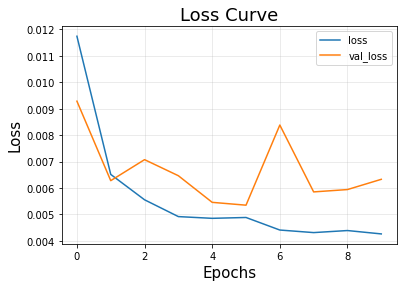

In [27]:
plt.plot(history.epoch,history.history['loss'],label="loss") # Loss curve for training set
plt.plot(history.epoch,history.history['val_loss'],label="val_loss") # Loss curve for validation set

plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 30495 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23454 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 30495 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 23454 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20540 missing from current font.
  font.set_text

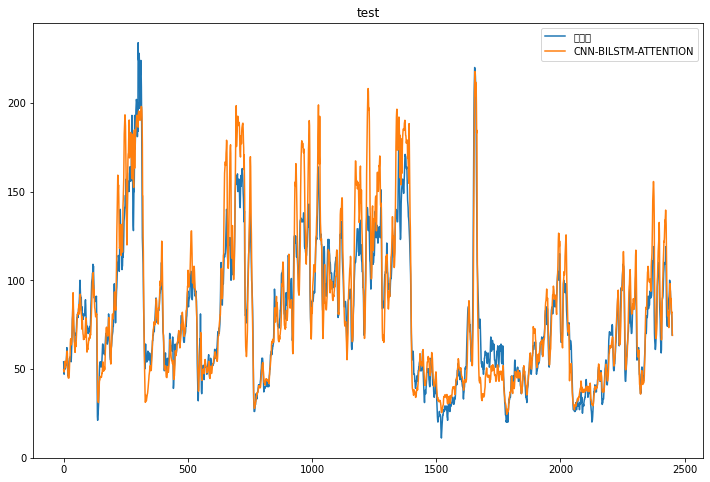

In [28]:
#训练和测试 真实值和预测值对比
plt.figure(figsize=(12, 8))
# plt.subplot(2, 2, 1)
sns.lineplot(x=range(len(y_test1)),y=y_test1,label='真实值')
sns.lineplot(x=range(len(y_test_predict3)),y=y_test_predict3,label='CNN-BILSTM-ATTENTION')
plt.legend()
plt.title('test')
# plt.subplot(2, 2, 2)
# sns.lineplot(x=range(len(y_train1)),y=y_train1.reshape(1,-1)[0],label='true')
# sns.lineplot(x=range(len(y_train_predict1)),y=y_train_predict1.reshape(1,-1)[0],label='predict')
# plt.legend()
# plt.title('train')
plt.show()

## 模型比较

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 30495 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23454 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 30495 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 23454 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20540 missing from current font.
  font.set_text

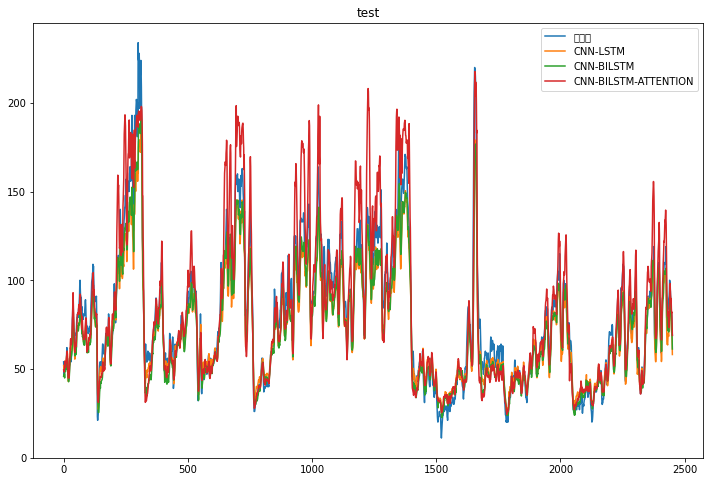

In [29]:
#训练和测试 真实值和预测值对比
plt.figure(figsize=(12, 8))
# plt.subplot(2, 2, 1)
sns.lineplot(x=range(len(y_test1)),y=y_test1,label='真实值')
sns.lineplot(x=range(len(y_test_predict1)),y=y_test_predict1,label='CNN-LSTM')
sns.lineplot(x=range(len(y_test_predict2)),y=y_test_predict2,label='CNN-BILSTM')
sns.lineplot(x=range(len(y_test_predict3)),y=y_test_predict3,label='CNN-BILSTM-ATTENTION')
plt.legend()
plt.title('test')
# plt.subplot(2, 2, 2)
# sns.lineplot(x=range(len(y_train1)),y=y_train1.reshape(1,-1)[0],label='true')
# sns.lineplot(x=range(len(y_train_predict1)),y=y_train_predict1.reshape(1,-1)[0],label='predict')
# plt.legend()
# plt.title('train')
plt.show()

In [30]:
mae_list=[cnn_lstm_mae,cnn_bilstm_mae,cnn_bilstm_a_mae]
mse_list=[cnn_lstm_mse,cnn_bilstm_mse,cnn_bilstm_a_mse]
rmse_list=[cnn_lstm_rmse,cnn_bilstm_rmse,cnn_bilstm_a_rmse]
mape_list=[cnn_lstm_mape,cnn_bilstm_mape,cnn_bilstm_a_mape]
result=pd.DataFrame([mae_list,mse_list,rmse_list,mape_list]).T
result.columns=['mae','mse','rmse','mape']
result.index=['cnn_lstm','cnn_bilsmt','cnn_bilstm_attention']
result

,mae,mse,rmse,mape
cnn_lstm,8.69,138.02,11.75,11.49%
cnn_bilsmt,8.66,132.07,11.49,12.22%
cnn_bilstm_attention,10.49,240.73,15.52,12.29%
